In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

## Complex distribution

In [2]:
# create random variable for vectors of gamma distributed RV's
mutable struct ComplexNormal <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function ComplexNormal(out, μ, Γ, C; id=ForneyLab.generateId(ComplexNormal))
        @ensureVariables(out, μ, Γ, C)
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        ForneyLab.addNode!(currentGraph(), self)
        self.i[:out] = self.interfaces[1] = ForneyLab.associate!(Interface(self), out)
        self.i[:μ] = self.interfaces[2] = ForneyLab.associate!(Interface(self), μ)
        self.i[:Γ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), Γ)
        self.i[:C] = self.interfaces[4] = ForneyLab.associate!(Interface(self), C)

        return self
    end
end

format(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = "$(slug(ComplexNormal))(μ=$(format(dist.params[:μ])), Γ=$(format(dist.params[:Γ])), C=$(format(dist.params[:C])))"

ProbabilityDistribution(::Type{ForneyLab.Multivariate}, ::Type{ComplexNormal}; μ::Array{Complex{Float64},1}, Γ::Array{Complex{Float64},2}, C::Array{Complex{Float64},2}) = ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}(Dict(:μ=>μ, :Γ=>Γ, :C=>C))
ProbabilityDistribution(::Type{ComplexNormal}; μ::Array{Complex{Float64},1}, Γ::Array{Complex{Float64},2}, C::Array{Complex{Float64},2}) = ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}(Dict(:μ=>μ, :Γ=>Γ, :C=>C))
ProbabilityDistribution(::Type{ComplexNormal}; μ::Array{Complex{Float64},1}, Γ::Array{Float64,2}, C::Array{Complex{Float64},2}) = ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}(Dict(:μ=>μ, :Γ=>Γ.+0im, :C=>C))

function ForneyLab.prod!( x::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal},
                          y::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal},
                          z::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}=ProbabilityDistribution(ForneyLab.Multivariate, ComplexNormal, μ=zeros(size(x.params[:μ])).+0im, Γ=(1e10+1e10im)*Ic(length(x.params[:μ])), C=mat(0.0+0.0im)))

    # TOO SIMPLIFIED (CASE FOR C=0 -> circular symmetry)
    z.params[:Γ] = inv(inv(x.params[:Γ]) + inv(y.params[:Γ])) .+ 0.0im
    z.params[:μ] = z.params[:Γ]*(inv(x.params[:Γ])*x.params[:μ] + inv(y.params[:Γ])*y.params[:μ]) .+ 0.0im
    z.params[:C] = mat(0.0+0.0im)
        
    return z
end

unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:μ] # unsafe mean  
ForneyLab.unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:μ] # unsafe mean  
unsafeCov(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:Γ] # unsafe mean  
ForneyLab.unsafeCov(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:Γ] # unsafe mean  

In [3]:
ruleSPComplexNormalOutNPPP(msg_out::Nothing, 
                           msg_μ::Message{PointMass},
                           msg_Γ::Message{PointMass},
                           msg_C::Message{PointMass}) =
                           Message(ForneyLab.Multivariate, ComplexNormal, μ=deepcopy(msg_μ.dist.params[:m]), Γ=deepcopy(msg_Γ.dist.params[:m]), C=deepcopy(msg_C.dist.params[:m]))

ruleSPComplexNormalOutNPPP (generic function with 1 method)

In [4]:
ruleSPComplexNormalIn1PNPP(msg_out::Message{PointMass}, 
                           msg_μ::Nothing,
                           msg_Γ::Message{PointMass},
                           msg_C::Message{PointMass}) =
                           Message(ForneyLab.Multivariate, ComplexNormal, μ=deepcopy(msg_out.dist.params[:m]), Γ=deepcopy(msg_Γ.dist.params[:m]), C=deepcopy(msg_C.dist.params[:m]))

ruleSPComplexNormalIn1PNPP (generic function with 1 method)

In [5]:
ruleSPComplexNormalOutNCPP(msg_out::Nothing, 
                           msg_μ::Message{ComplexNormal, ForneyLab.Multivariate},
                           msg_Γ::Message{PointMass},
                           msg_C::Message{PointMass}) =
                           Message(ForneyLab.Multivariate, ComplexNormal, μ=deepcopy(msg_μ.dist.params[:μ]), Γ=deepcopy(msg_Γ.dist.params[:m]) + ForneyLab.unsafeCov(msg_μ.dist), C=deepcopy(msg_C.dist.params[:m]))

ruleSPComplexNormalOutNCPP (generic function with 1 method)

In [6]:
ruleSPComplexNormalIn1CNPP(msg_out::Message{ComplexNormal, ForneyLab.Multivariate}, 
                           msg_μ::Nothing,
                           msg_Γ::Message{PointMass},
                           msg_C::Message{PointMass}) =
    ruleSPComplexNormalOutNCPP(msg_mean, msg_out, msg_Γ, msg_C)

ruleSPComplexNormalIn1CNPP (generic function with 1 method)

In [7]:
ruleVBComplexNormalOut(dist_out::Any,
                       dist_μ::ProbabilityDistribution{ForneyLab.Multivariate},
                       dist_Γ::ProbabilityDistribution{ForneyLab.MatrixVariate},
                       dist_C::ProbabilityDistribution{ForneyLab.MatrixVariate}) =
                       Message(ForneyLab.Multivariate, ComplexNormal, μ=ForneyLab.unsafeMean(dist_μ), Γ=ForneyLab.unsafeMean(dist_Γ), C=ForneyLab.unsafeMean(dist_C))

ruleVBComplexNormalOut (generic function with 1 method)

In [8]:
ruleVBComplexNormalIn1(dist_out::ProbabilityDistribution{ForneyLab.Multivariate},
                       dist_μ::Any,
                       dist_Γ::ProbabilityDistribution{ForneyLab.MatrixVariate},
                       dist_C::ProbabilityDistribution{ForneyLab.MatrixVariate}) =
                       Message(ForneyLab.Multivariate, ComplexNormal, μ=ForneyLab.unsafeMean(dist_out), Γ=ForneyLab.unsafeMean(dist_Γ), C=ForneyLab.unsafeMean(dist_C))

ruleVBComplexNormalIn1 (generic function with 1 method)

In [9]:
@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Nothing, Message{PointMass}, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalOutNPPP)

@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Message{PointMass}, Nothing, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalIn1PNPP)

@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Nothing, Message{ComplexNormal}, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalOutNCPP)

@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Message{ComplexNormal}, Nothing, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalIn1CNPP)

@naiveVariationalRule(:node_type     => ComplexNormal,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VBComplexNormalOut)

@naiveVariationalRule(:node_type     => ComplexNormal,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VBComplexNormalIn1)

## Complex to multivariate distribution

In [10]:
mutable struct Complex2Real <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function Complex2Real(rx, cx; id=ForneyLab.generateId(Complex2Real))
        
        # NOTE: This node assumes independence amongst the real and imaginary part of the complex random variable.
        
        # ensure that the input arguments are random variables
        @ensureVariables(rx, cx) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 2), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:rx] = self.interfaces[1] = ForneyLab.associate!(Interface(self), rx)
        self.i[:cx] = self.interfaces[2] = ForneyLab.associate!(Interface(self), cx)
        
        # return object
        return self
    end
end

In [19]:
function ruleSPComplex2RealOutNC(marg_rx::Nothing, 
                                 marg_cx::Message{ComplexNormal})

    # calculate mean of complex random variable
    μ_cx = ForneyLab.unsafeMean(marg_cx.dist)
    
    # calculate covariance of complex random variable
    Γ_cx = ForneyLab.unsafeCov(marg_cx.dist)
    
    # convert the mean vector μ_cx to the mean vector [real(μ_cx), imag(μ_cx)]
    μ_rx = vcat(real.(μ_cx), imag.(μ_cx))
    
    # convert the covariance matrix into the covariance matrix [0.5*Re(Γ), 0; 0, 0.5*Re(Γ)]
    # Σ_rx = [0.5*real(Γ_cx), zeros(size(Γ_cx)); zeros(size(Γ_cx)), 0.5*real(Γ_cx)]
    
    # calculate precision matrix
    w_rx = [[0.5*inv(real(Γ_cx)), zeros(size(Γ_cx))] [zeros(size(Γ_cx)), 0.5*inv(real(Γ_cx))]]
    
    # create sum-product message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=w_rx*μ_rx, w=w_rx)


end

ruleSPComplex2RealOutNC (generic function with 1 method)

In [20]:
function ruleSPComplex2RealIn1GN(marg_rx::Message{GaussianWeightedMeanPrecision},
                                 marg_cx::Nothing)

    # calculate mean of random variable
    μ_rx = ForneyLab.unsafeMean(marg_rx.dist)
    
    # calculate covariance of random variable
    Σ_cx = ForneyLab.unsafeCov(marg_rx.dist)
    
    # calculate complex vector length
    N = Int(round(length(μ_rx)/2))
    
    # calculate mean vector of complex random variable
    μ_cx = μ_rx[1:N] + 1im*μ_rx[N+1:end]
    
    # calculate complex covariance matrix of complex random variable
    V_xx = Σ_cx[1:N, 1:N]
    V_yy = Σ_cx[N+1:end, N+1:end]
    Γ_cx = V_xx + V_yy .+ 0.0im
    
    # create sum-product message
    return Message(ForneyLab.Multivariate, ComplexNormal, μ=μ_cx, Γ=Γ_cx, C=mat(0.0+0.0im))

end

ruleSPComplex2RealIn1GN (generic function with 1 method)

In [21]:
@sumProductRule(:node_type     => Complex2Real,
                :outbound_type => Message{GaussianWeightedMeanPrecision},
                :inbound_types => (Nothing, Message{ComplexNormal}),
                :name          => SPComplex2RealOutNC)

@sumProductRule(:node_type     => Complex2Real,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Message{GaussianWeightedMeanPrecision}, Nothing),
                :name          => SPComplex2RealIn1GN)

## Create factorgraph

In [148]:
nr_freqs = 4
bufsize = 8

8

In [149]:
# create factor graph
fg = FactorGraph()

@RV cx_min ~ ComplexNormal(placeholder(:μ_cx_min, dims=(nr_freqs,)), placeholder(:Γ_cx_min, dims=(nr_freqs, nr_freqs)), mat(0.0+0.0im))

@RV cx ~ ComplexNormal(cx_min, placeholder(:Γ_p, dims=(nr_freqs, nr_freqs)), mat(0.0+0.0im))

@RV rx ~ Complex2Real(cx)

@RV x = placeholder(:C, dims=(bufsize, 2*nr_freqs))*rx

@RV y ~ GaussianMeanVariance(x, placeholder(:Σ_y, dims=(bufsize, bufsize)))

placeholder(y, :y, dims=(bufsize,))

# draw factor graph
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14621419331875597510 -->
 14621419331875597510 
 
 placeholder_Γ_p 
 
<!-- 8081694067437088106 -->
 8081694067437088106 
 
 ComplexNormal 
 complexnormal_2 
 
<!-- 8081694067437088106--14621419331875597510 -->
 8081694067437088106--14621419331875597510 
 
 Γ_p 
 1 out 
 3 Γ 
 
<!-- 344325480263984131 -->
 344325480263984131 
 
 ComplexNormal 
 complexnormal_1 
 
<!-- 8081694067437088106--344325480263984131 -->
 8081694067437088106--344325480263984131 
 
 cx_min 
 1 out 
 2 μ 
 
<!-- 4371390254263462689 -->
 4371390254263462689 
 
 clamp_2 
 
<!-- 8081694067437088106--4371390254263462689 -->
 8081694067437088106--4371390254263462689 
 
 clamp_2 
 1 out 
 4 C 
 
<!-- 18034167147070964854 -->
 18034167147070964854 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 2574259068874469368 -->
 2574259068874469368 
 
 × 
 multiplication_1 
 
<!-- 18034167147070964854--2574259068874469368 -->
 18034167147070964854--2574259068874469368 
 
 x 
 1 out 
 2 m 
 
<!-- 10745523203005857594 -->
 10745523203005857594 
 
 placeholder_Σ_y 
 
<!-- 18034167147070964854--10745523203005857594 -->
 18034167147070964854--10745523203005857594 
 
 Σ_y 
 1 out 
 3 v 
 
<!-- 1271765939308857309 -->
 1271765939308857309 
 
 placeholder_Γ_cx_min 
 
<!-- 344325480263984131--1271765939308857309 -->
 344325480263984131--1271765939308857309 
 
 Γ_cx_min 
 1 out 
 3 Γ 
 
<!-- 6787885037477720696 -->
 6787885037477720696 
 
 placeholder_μ_cx_min 
 
<!-- 344325480263984131--6787885037477720696 -->
 344325480263984131--6787885037477720696 
 
 μ_cx_min 
 1 out 
 2 μ 
 
<!-- 9649776111407321477 -->
 9649776111407321477 
 
 clamp_1 
 
<!-- 344325480263984131--9649776111407321477 -->
 344325480263984131--9649776111407321477 
 
 clamp_1 
 1 out 
 4 C 
 
<!-- 16870480892658329651 -->
 16870480892658329651 
 
 Complex2Real 
 complex2real_1 
 
<!-- 16870480892658329651--8081694067437088106 -->
 16870480892658329651--8081694067437088106 
 
 cx 
 1 out 
 2 cx 
 
<!-- 1995906378610780474 -->
 1995906378610780474 
 
 placeholder_C 
 
<!-- 2574259068874469368--16870480892658329651 -->
 2574259068874469368--16870480892658329651 
 
 rx 
 1 rx 
 2 in1 
 
<!-- 2574259068874469368--1995906378610780474 -->
 2574259068874469368--1995906378610780474 
 
 C 
 1 out 
 3 a 
 
<!-- 17909563599923831222 -->
 17909563599923831222 
 
 placeholder_y 
 
<!-- 17909563599923831222--18034167147070964854 -->
 17909563599923831222--18034167147070964854 
 
 y 
 1 out 
 1 out

## Create algorithm

In [150]:
# generate algorithm
algo = sumProductAlgorithm(cx)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 5))

messages[1] = ruleSPComplexNormalOutNPPP(nothing, Message(ForneyLab.Multivariate, PointMass, m=data[:μ_cx_min]), Message(MatrixVariate, PointMass, m=data[:Γ_cx_min]), Message(MatrixVariate, PointMass, m=mat(0.0 + 0.0im)))
messages[2] = ruleSPComplexNormalOutNCPP(nothing, messages[1], Message(MatrixVariate, PointMass, m=data[:Γ_p]), Message(MatrixVariate, PointMass, m=mat(0.0 + 0.0im)))
messages[3] = ruleSPGaussianMeanVarianceMPNP(Message(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, Message(MatrixVariate, PointMass, m=data[:Σ_y]))
messages[4] = ruleSPMultiplicationIn1GNP(messages[3], nothing, Message(MatrixVariate, PointMass, m=data[:C]))
messages[5] = ruleSPComplex2RealIn1GN(messages[4], nothing)

marginals[:cx] = messages[2].dist * messages[5].dist

return marginals

end

end # block


## Generate data

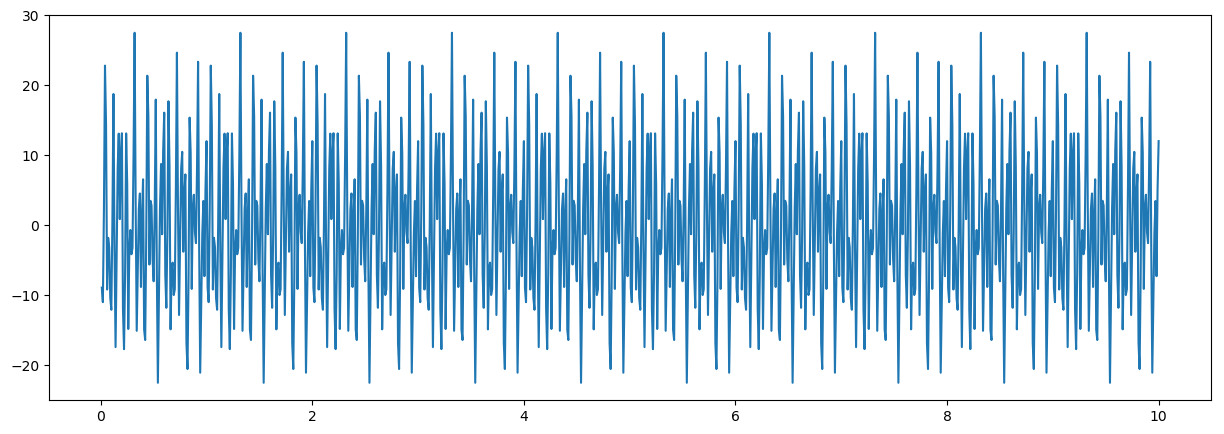

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003459C208>

In [151]:
f = [7, 15, 25, 40]
fs = 100
s = [1.0+5.0im,  -2.0-9.0im, 11.0-0.1im, 2.0-3.0im]
N = 1000
t = collect(1:N)/fs

x = squeeze(sum(real.(s).*cos.(2*pi*f*t') + imag.(s).*sin.(2*pi*f*t'), dims=1))
plt.figure(figsize=(15,5))
plt.plot(t,x)

## Do inference


In [156]:
μ_cx_min = zeros(nr_freqs) + 1im*zeros(nr_freqs)
Γ_cx_min = 1e1*Ic(nr_freqs).+0im
Γ_p = 1e-1*Ic(nr_freqs).+0im
Σ_y = 1e-0*Ic(bufsize)
μ_cx_mem = Array{Complex{Float64},2}(undef, N,length(f))

for n = bufsize:N
    
    data = Dict(:μ_cx_min => μ_cx_min,
                :Γ_cx_min => Γ_cx_min,
                :Γ_p => Γ_p,
                :Σ_y => Σ_y,
                :C => vcat(cos.(2*pi*f*t[n-bufsize+1:n]'), sin.(2*pi*f*t[n-bufsize+1:n]'))', 
                :y => x[n-bufsize+1:n])
    marginals = Dict()
    step!(data, marginals)
    
    μ_cx_min = ForneyLab.unsafeMean(marginals[:cx])
    Γ_cx_min = ForneyLab.unsafeCov(marginals[:cx])
    
    μ_cx_mem[n,:] = μ_cx_min
    
end


In [157]:
μ_cx_min

4-element Array{Complex{Float64},1}:
 1.0000000000022993 + 5.000000000000442im  
 -1.999999999999218 - 8.999999999994191im  
 10.999999999996115 - 0.09999999999829678im
  1.999999999999248 - 2.9999999999984057im 

In [158]:
s = [1.0+5.0im,  -2.0-9.0im, 11.0-0.1im, 2.0-3.0im]


4-element Array{Complex{Float64},1}:
  1.0 + 5.0im
 -2.0 - 9.0im
 11.0 - 0.1im
  2.0 - 3.0im

In [159]:
μ_cx_mem

1000×4 Array{Complex{Float64},2}:
 8.09636e-315+1.63747e-315im       0.0+0.0im      …      0.0+0.0im    
 8.12639e-320-2.83706e-11im        0.0+0.0im             0.0+0.0im    
 -3.04985e-11-2.37282e-11im        0.0+0.0im             0.0+0.0im    
 -3.50221e-11+6.52171e-315im       0.0+0.0im             0.0+0.0im    
 6.92005e-315+6.92e-315im          0.0+0.0im             0.0+0.0im    
 6.91993e-315+6.91998e-315im       0.0+0.0im      …      0.0+0.0im    
       2.5904+1.80585im            0.0+0.0im             0.0+0.0im    
     0.714386+4.9937im        -2.56206-7.96819im     1.82603-2.78089im
     0.750002+5.08041im       -2.27277-8.57248im        1.93-2.94012im
     0.853599+5.07895im       -2.16781-8.74495im     1.98495-2.97645im
      0.94049+5.05249im       -2.09921-8.82071im  …  1.98179-2.97622im
     0.990754+5.01853im       -2.03873-8.88341im     1.98574-2.97653im
      1.00021+5.00288im        -2.0079-8.92728im     1.99276-2.99134im
             ⋮                             